## Fine-tuning Transfer Learning

In fine-tuning transfer learning the pre-trained model weights from another model are unfrozen and tweaked during to better suit your own data.

Fine-tuning is a type of transfer learning where you:

Start with a pre-trained model (e.g., ResNet, BERT, GPT).

Adjust its parameters (weights) by continuing training on your smaller, task-specific dataset.

In this section you can optionally:

1. Freeze some layers (e.g., early layers that detect generic features like edges/word syntax).

2. Train the entire model end-to-end with a lower learning rate.

OR

3. Update only the later layers (more task-specific features like organs in X-rays or sentiment in reviews), which we have already implemented in the previous notebook.



Let us first import TensorFlow and che its version:

In [1]:
import tensorflow as tf

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.19.0


And then check if we are using either GPU or CPU?

In [2]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


Also, we have to download the module `helper_functions.py module`:

In [3]:
import os

# GitHub raw URL of the module
url = "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py"
filename = "helper_functions.py"

# Download only if not already present
if not os.path.exists(filename):
    print(f"Downloading {filename} from GitHub...")
    !wget -q -O {filename} {url}
    print(f"Downloaded {filename} to the current directory.")
else:
    print(f"{filename} already exists in the current directory.")

Downloaded helper_functions.py to the current directory.


In [4]:
# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

Now download data as we did in the previous notebook.

In [5]:
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

# OR alternatively

# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# unzip_data("10_food_classes_10_percent.zip")

--2025-09-23 17:38:31--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 192.178.212.207, 173.194.193.207, 173.194.194.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|192.178.212.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   166MB/s    in 1.0s    

2025-09-23 17:38:33 (166 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



Typically the file structure should be like:

```
10_food_classes_10_percent/          <- parent directory
├── train                            <- training images
│   ├── pizza
│   │   │   1647351.jpg
│   │   │   1647352.jpg
│   │   │   ...
│   └── steak
│       │   1648001.jpg
│       │   1648050.jpg
│       │   ...
│
└── test                             <- testing images
    ├── pizza
    │   │   1001116.jpg
    │   │   1507019.jpg
    │   │   ...      
    └── steak
        │   100274.jpg
        │   1653815.jpg
        │   ...
```

In [6]:
import tensorflow as tf

# Create training and test directories
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

# Create data inputs
IMG_SIZE = (224, 224) # define image size
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # what type are the labels?
                                                                            batch_size=32) # batch_size is 32 by default, this is generally a good number
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Calling a TensorFlow utility above (`tf.keras.preprocessing.image_dataset_from_directory`), we simply and quickly build a dataset of images from a folder structure.

If you want to see an example batch of data, you could use the `take()` method.

In [7]:
# See an example batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[161.43878    137.43878    112.72449   ]
   [164.5357     138.5357     112.82143   ]
   [168.56631    142.63266    114.28571   ]
   ...
   [ 32.127575    18.556103     8.91331   ]
   [ 35.045967    16.045965     9.045966  ]
   [ 39.68874     20.688738    13.688738  ]]

  [[162.44897    139.5204     107.16327   ]
   [172.09694    149.16838    116.81123   ]
   [169.88776    145.88776    111.60204   ]
   ...
   [ 32.403122    16.045914     7.403122  ]
   [ 38.005142    19.005142    12.005142  ]
   [ 39.857037    19.857038    12.8570385 ]]

  [[172.32143    152.67857    110.96429   ]
   [173.17857    153.5357     112.60714   ]
   [172.18877    149.7602     109.40306   ]
   ...
   [ 37.545937    19.448948    11.59187   ]
   [ 39.887787    20.102072    13.102072  ]
   [ 41.790684    19.433542    13.219255  ]]

  ...

  [[231.84694    213.56633    178.40816   ]
   [230.95918    212.95918    175.10204   ]
   [230.72957    213.23468    173.0663    ]
   ...
   [205.0664     184.898

Now we are ready to launch our first model (the baseline)...

We’ll use the `tf.keras.applications` module, which provides a collection of pre-trained computer vision models (trained on ImageNet), along with the Keras Functional API to build our model. But what are the right steps one should take...?

Model 0: Building a transfer learning model using the Keras Functional API

In order to create a baseline in our case, you can do as follows:

1. Instantiate a pre-trained base model object by choosing a target model such as `EfficientNetV2B0` and setting the `include_top` parameter to `False`.
2. Set the base model's `trainable` attribute to `False` to freeze all of the weights in the pre-trained model.
3. Define an input layer for our model (data shape expected by the model)
4. Normalize the inputs to our model if it requires (e.g., `EfficientNetV2B0`).
5. Pass the inputs to the base model.
6. Pool the outputs of the base model into a shape compatible with the output activation layer (turn base model output tensors into same shape as label tensors)
7. Create an output activation layer via `tf.keras.layers.Dense()`
8. Merge the inputs and outputs layer into a new model using `tf.keras.Model()`
9. Compile the model, passing the loss function and optimizer
10. Fit the model for as many epochs as necessary.

In [8]:
# Create base model
base_model = tf.keras.applications.EfficientNetV2B0(include_top=False)

# Freeze base model layers
base_model.trainable = False

# Create the input layer
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# If using ResNet50V2, add this to speed up convergence, remove for EfficientNetV2
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# Pass the inputs to the base model
x = base_model(inputs)

print(f"Shape after base_model: {x.shape}")

# Average pool the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# Create the activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# Merge inputs and outputs into a new model via Model()
model_0 = tf.keras.Model(inputs, outputs)

# Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_0 = model_0.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data_10_percent,
                        validation_steps=int(0.15 * len(test_data_10_percent)),
                        callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                               experiment_name="model_0_baseline")])

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: training_logs/model_0_baseline/20250923-173836
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.3362 - loss: 2.0231 - val_accuracy: 0.7557 - val_loss: 1.2758
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.7128 - loss: 1.2164 - val_accuracy: 0.8494 - val_loss: 0.8471
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8102 - loss: 0.8758 - val_accuracy: 0.8494 - val_loss: 0.7014
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8707 - loss: 0.6802 - val_accuracy: 0.8438 - val_loss: 0.6266
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8795 - loss: 0.5662 - val_accuracy: 0.8381 - val_loss: 0.5580


What we did exactly is:

We took our custom dataset, fed it into a pre-trained model (`EfficientNetV2B0`), let it identify meaningful patterns, and then added our own output layer to match the number of classes we needed.

Keras Functional API is used instead of using the Sequential one to create the model.

### Model Inspection

Before proceeding with model inspection, it is important to note that the model is currently in the process of being fine-tuned, and as such, its weights and configurations may not fully reflect the final intended setup. At this stage, we will focus on examining the model’s architecture and layer structure to better understand its components, verify the expected configuration, and ensure that the fine-tuning process is applied to the correct parameters.


In [9]:
# Check layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_layer
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 b

In [10]:
base_model.summary()

Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, None,      │          0 │ input_layer[0][0] │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, None,      │          0 │ rescaling[0][0]   │
│ (Normalization)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │        864 │ normalization[0]… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │      4,608 │ stem_activation[… │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, None,      │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, None,      │          0 │ block1a_project_… │
│ (Activation)        │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, None,      │      9,216 │ block1a_project_… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, None,      │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, None,      │          0 │ block2a_expand_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, None,      │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, None,      │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, None,      │     36,864 │ block2a_project_… │
│ (Conv2D)            │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, None,      │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, None,      │          0 │ block2b_expand_b

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,919,312 (22.58 MB)

What about he summary of the model we just constructed?

In [11]:
model_0.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,957,744 (22.73 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

 Optimizer params: 25,622 (100.09 KB)

**NOTE!** A pretrained model outputs a feature vector (a long tensor of numbers, in our case, this is the output of the `tf.keras.layers.GlobalAveragePooling2D()` layer) which can then be used to extract patterns out of.

As you can see, the only trainable parameters in the model are those in the output layer.



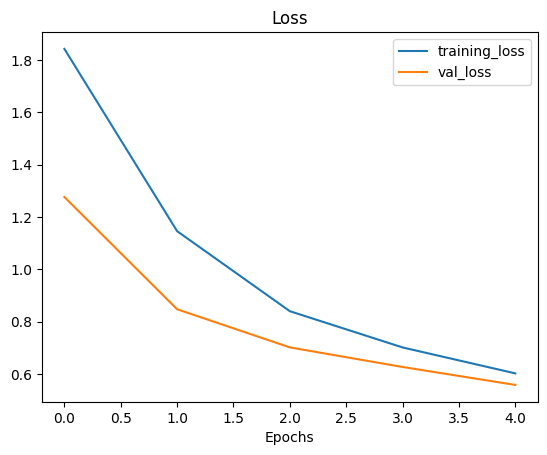

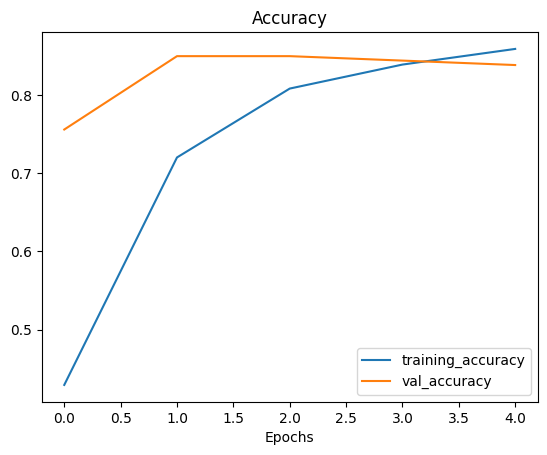

In [12]:
plot_loss_curves(history_0)

### Extract a Feature Vector

Now let us see what a single feature vector of a trained model might look like...



In [13]:
# Define input tensor shape (same number of dimensions as the output of efficientnetv2-b0)
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shapes of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global averaged pooled input tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.26454744]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728497  0.40125778 -1.4145442 ]
   [-0.59318566 -1.6617213   0.33567193]
   [ 0.10815629  0.2347968  -0.56668764]
   [-0.35819843  0.88698626  0.5274477 ]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840445 -0.28855976]]

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global averaged pooled input tensor: (1, 3)


The operation above can also be replicated by `tf.reduce_mean()`, specifying the right axis.

In [15]:
# the same as GlobalAveragePooling2D()
tf.reduce_mean(input_tensor, axis=[1, 2]) # average across the middle axes

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840445, -0.28855976]], dtype=float32)>